In [50]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from torch.optim import SGD, Adam

import matplotlib.pyplot as plt

from datasets import get_dataset    
from loss_fns import get_loss
from utils import solve

torch.set_default_dtype(torch.float64)

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [51]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [3]:
def logistic_reg(w, X, y):
    return torch.mean(torch.log(1 + torch.exp(-y * (X @ w))))

def nllsq(w, X, y):
    return torch.mean( ( y - (1/(1 + torch.exp(-X @ w ))) )**2 )

def rademacher_old(weights):
    return torch.round(torch.rand_like(weights)) * 2 - 1

def diag_estimate_old(weights, grad, iters):
    Ds = []
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.append((hvp*z))

    return torch.mean(torch.stack(Ds), 0)


def load_result(dataset, percent, scale, batch_size, epochs, loss_class, optimizer_class, lr, preconditioner, slack_method, lmd, mu, seed):
    
    results_dir = os.getenv("RESULTS_DIR")
    
    directory = f"{results_dir}/{dataset}/percent_{percent}/scale_{scale}/bs_{batch_size}" \
    f"/epochs_{epochs}/{loss_class}/{optimizer_class}/lr_{lr}/precond_{preconditioner}/slack_{slack_method}/lmd_{lmd}/mu_{mu}/seed_{seed}"

    if not os.path.isdir(directory):
        return None

    grad_norm_sq = []
    loss = []
    slack = []

    grad_norm_sq = torch.load(f"{directory}/grad_norm_sq")
    loss = torch.load(f"{directory}/loss")

    if slack_method != "none" and optimizer_class != "bsps2":
        slack = torch.load(f"{directory}/slack")
    else:
        slack = [0 for x in loss]

    return [[x, y, z] for x, y, z in zip(loss, grad_norm_sq, slack)]

def citardouq_solve(a, b, c):
    det = b * b - 4 * a * c
    if det < 1e-40:
        x1 = 0.0
        x2 = 0.0
    else:
        x1 = (2 * c) / (-b - np.sqrt(det))
        x2 = (2 * c) / (-b + np.sqrt(det))
    return np.asarray([x1, x2])

In [106]:
torch.random.manual_seed(0)

# parameters for D
alpha = 1e-4
beta=0.999
# parameters for slack
lmd = 0.01
mu = 0.1

# Setup
batch_size = 8
dataset_name = "colon-cancer"
percentage = 1.0
uninterpolatible = False

# training 
EPOCHS = 5
loss_name = "logreg"
loss_class = get_loss(loss_name)

scale_k = 0
train_data, train_target = get_dataset(dataset_name, batch_size, percentage, scale_k)

X = train_data
Y = train_target
if uninterpolatible:
    X = torch.cat((train_data, train_data, train_data))
    Y = torch.cat((train_target, train_target, -train_target))
    
train_data = X.to(torch.get_default_dtype())
train_target = Y.to(torch.get_default_dtype())
train_load = data_utils.TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=True)

/home/farshed.abdukhakimov/projects/sps2/datasets


In [132]:
np.random.seed(0)
n = 1000
d = 100
dataset_name = f"synthetic-{n}x{d}"
modified = True
A = np.random.randn(n,d)

if modified:
    U, S, VH = np.linalg.svd(A)
    S *= 0.0
    S = np.asarray([1/((x+1)**2) for x in range(S.shape[0])])
    A = np.dot(U[:, :S.shape[0]] * S, VH)
    dataset_name += "-modified"

xopt = np.random.randn(d)
b = A @ xopt 
train_data = torch.Tensor(A)
train_target = torch.Tensor(b)
xopt = torch.Tensor(xopt)

EPOCHS = 5
train_load = torch.utils.data.TensorDataset(train_data, train_target)
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_load, batch_size=batch_size, shuffle=True)

def fun(At,x,bt):
    return 1/2*torch.mean(torch.norm(At@x-bt)**2)

class MSELoss(torch.nn.Module):
    def __init__(self, params):
        self.params = params
        super().__init__()

    def forward(self, input_, target):
        return 1/2 * torch.mean( torch.norm(input_ @ self.params - target )**2 )
    
loss_class = MSELoss

In [133]:
def train_optimizer(optimizer, lr):
    # parameters
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()
    optimizer = optimizer([w], lr=lr)
    loss_function = loss_class(w)

    # save loss and grad size to history
    hist = []
    loss = loss_function(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
    hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

    for step in range(EPOCHS):
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)
            optimizer.zero_grad()
            loss = loss_function(batch_data, batch_target)
            loss.backward()
            optimizer.step()

            loss = loss_function(train_data.to(device), train_target.to(device))
            g, = torch.autograd.grad(loss, w, create_graph=True)
            print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
            hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

    return hist

# SGD

In [134]:
sgd_lr = 0.005
hist_sgd = load_result(dataset_name, percentage, scale_k, batch_size, EPOCHS, loss_name, "sgd", sgd_lr, "none", "none", lmd, mu, 0)

if not hist_sgd:
    hist_sgd = train_optimizer(SGD, sgd_lr)

Loss: 0.05804759607091615 | GradNorm^2: 0.08442473536801805
Loss: 0.057986034894339636 | GradNorm^2: 0.0843037265381537
Loss: 0.05793251067255413 | GradNorm^2: 0.0841982082043911
Loss: 0.05787283676798168 | GradNorm^2: 0.08408079311129073
Loss: 0.057820720110565584 | GradNorm^2: 0.08397829823301121
Loss: 0.05775933233217642 | GradNorm^2: 0.08385725255710655
Loss: 0.05772158834170776 | GradNorm^2: 0.0837826750290633
Loss: 0.05767282922757301 | GradNorm^2: 0.08368673762716973
Loss: 0.057627414253780485 | GradNorm^2: 0.08359729351576592
Loss: 0.057571728913783746 | GradNorm^2: 0.08348716336466445
Loss: 0.05750287373079566 | GradNorm^2: 0.0833514778829613
Loss: 0.05743692307436124 | GradNorm^2: 0.08322181158909056
Loss: 0.057393718428191506 | GradNorm^2: 0.08313687498024161
Loss: 0.057331417600132654 | GradNorm^2: 0.08301451379045276
Loss: 0.057287956159683184 | GradNorm^2: 0.08292916803604625
Loss: 0.057244242252327555 | GradNorm^2: 0.08284302251213063
Loss: 0.05721136148546257 | GradNorm

# Adam

In [135]:
adam_lr = 0.1
hist_adam = load_result(dataset_name, percentage, scale_k, batch_size, EPOCHS, loss_name, "adam", sgd_lr, "none", "none", lmd, mu, 0)

if not hist_adam:
    hist_adam = train_optimizer(Adam, adam_lr)

Loss: 0.05804759607091615 | GradNorm^2: 0.08442473536801805
Loss: 0.14684279806612935 | GradNorm^2: 0.2662368900002784
Loss: 0.04029203713012596 | GradNorm^2: 0.06237039598744364
Loss: 0.016545596232446245 | GradNorm^2: 0.020783560324757387
Loss: 0.07021329548366007 | GradNorm^2: 0.13139171005106237
Loss: 0.03800364462563485 | GradNorm^2: 0.06808486660991413
Loss: 0.0051372584703512315 | GradNorm^2: 0.0026113621435098367
Loss: 0.01553274788255552 | GradNorm^2: 0.02351119733340245
Loss: 0.03778580115825253 | GradNorm^2: 0.06832358313574599
Loss: 0.027202937272579168 | GradNorm^2: 0.0478443868685558
Loss: 0.006244678710122875 | GradNorm^2: 0.006705932600198177
Loss: 0.005279794602354534 | GradNorm^2: 0.005719442631743599
Loss: 0.019016948246573365 | GradNorm^2: 0.034249134642205914
Loss: 0.024427949960950338 | GradNorm^2: 0.04606961780468276
Loss: 0.01421717479597439 | GradNorm^2: 0.02634654438883605
Loss: 0.0015011409201919285 | GradNorm^2: 0.0013950095012027796
Loss: 0.0045247259785037

# SP2+

In [136]:
def run_sp2plus():
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()
    loss_function = loss_class(w)
    # save loss and grad size to history
    hist = []
    loss = loss_function(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
    hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])
        
    for epoch in range(EPOCHS):

        for i, (batch_data, batch_target) in enumerate(train_dataloader):

            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            loss = loss_function(batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.clone().detach()

            loss_closure = lambda w: loss_function(batch_data, batch_target)
            hgp = torch.autograd.functional.hvp(loss_closure, w, g, create_graph=True)[1]

            with torch.no_grad():
                gnormsq = torch.norm(f_grad)**2
                sps_step = loss.item() / gnormsq
                w.sub_(sps_step * f_grad)
                gdiffHgp = torch.sub(f_grad, hgp, alpha=sps_step)
                if torch.norm(gdiffHgp)**2 > 1e-10:
                        w.sub_(0.5 * (sps_step**2) * gdiffHgp * torch.dot(f_grad, gdiffHgp)/ (torch.norm(gdiffHgp)**2))


            loss = loss_function(train_data.to(device), train_target.to(device))
            g, = torch.autograd.grad(loss, w, create_graph=True)
            print(f"[{i}] | Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
            # print(f"[{epoch+1}/{EPOCHS}] | Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
            hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

    return hist

In [137]:
hist_sp2plus = run_sp2plus()

Loss: 0.05804759607091615 | GradNorm^2: 0.08442473536801805
[0] | Loss: 0.09632228958624264 | GradNorm^2: 0.16657610500717096
[1] | Loss: 0.10278679912120002 | GradNorm^2: 0.18446501098203652
[2] | Loss: 0.06990958747703799 | GradNorm^2: 0.12138207651207791
[3] | Loss: 0.0655599085969531 | GradNorm^2: 0.11557815498427697
[4] | Loss: 0.030072333326226667 | GradNorm^2: 0.04602157568635157
[5] | Loss: 0.06509069799950137 | GradNorm^2: 0.1180028734024597
[6] | Loss: 0.024327299624558468 | GradNorm^2: 0.036879699611958305
[7] | Loss: 0.08541333047001519 | GradNorm^2: 0.16025641220461664
[0] | Loss: 0.05926904761450794 | GradNorm^2: 0.10877835968367969
[1] | Loss: 0.05704034492043207 | GradNorm^2: 0.10471105600127342
[2] | Loss: 0.02255780263862182 | GradNorm^2: 0.03627154595237494
[3] | Loss: 0.030876423433274115 | GradNorm^2: 0.053458111051088934
[4] | Loss: 0.025170908666002374 | GradNorm^2: 0.042512120460132086
[5] | Loss: 0.026814822153537504 | GradNorm^2: 0.046086071560954844
[6] | Los

# PSPS2
$
w^* = \arg\min_{w\in\mathbb{R} ^d}\frac{1}{2} \|w - w_t\|_{\nabla^2f(w)}^2 \nonumber \\
      \textit{s.t.} \quad f_i(w_t) +  \langle  \nabla  f_i(w_t), w-w_t\rangle +\frac{1}{2}\langle \nabla^2f(w)(w-w^t), w - w^t \rangle = 0
$

In [138]:
def run_psps2_hessian():
    # parameters
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

    loss_function = loss_class(w)

    # save loss and grad size to history
    hist = []
    loss = loss_function(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    f_grad = g.clone().detach()
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")

    lmd_star = torch.tensor(0.0)
    # hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), lmd_star])

    s = torch.zeros_like(w) # s = H_inv * grad
    r = f_grad - torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
    p = r.detach().clone()
    r_prev = torch.dot(r, r)
    MAX_ITER = 100


    for epoch in range(EPOCHS):

        for i, (batch_data, batch_target) in enumerate(train_dataloader):

            loss = loss_function(train_data.to(device), train_target.to(device))
            g, = torch.autograd.grad(loss, w, create_graph=True)
            print(f"[{i}] | Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
            hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), lmd_star.item()])
            

            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            loss = loss_function(batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.clone().detach()

            # CG is here
            s = torch.zeros_like(w) # s = H_inv * grad
            r = f_grad.clone()
            p = r.detach().clone()

            for cg_step in range(MAX_ITER):
                hvp = torch.autograd.grad(g, w, grad_outputs=p, retain_graph=True)[0]
                alpha_k = torch.dot(r, r) / torch.dot(p, hvp)
                s = s + alpha_k * p
                r_prev = r.clone()
                r = r - alpha_k * hvp
                if torch.norm(r) < 1e-10:
                    Ax = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]    
                    diff = torch.norm(Ax - f_grad)
                    print(f"Took {cg_step} to reach diff={diff}")
                    break

                beta_k = torch.dot(r, r) / torch.dot(r_prev, r_prev)
                p = r + beta_k * p
            
            gnorm_sq = torch.dot(f_grad, s)
            t = 2 * loss.item() - gnorm_sq
            det = 1 - (2 * loss.item() / t)
            if det < 0.0:
                lmd_star = torch.tensor(1.0)
                print(f"det: {det}")
                continue
            else:    
                root_1 = -1 + torch.sqrt(det)
                root_2 = -1 - torch.sqrt(det)
                lmd_star = torch.maximum(torch.tensor(0.0), torch.maximum(root_1, root_2))
            step = lmd_star / (1 + lmd_star) * s 
            with torch.no_grad():
                w.sub_(step)

    return hist

In [139]:
hist_psps2_hessian = run_psps2_hessian()

Loss: 0.05804759607091615 | GradNorm^2: 0.08442473536801805
[0] | Loss: 0.05804759607091615 | GradNorm^2: 0.08442473536801805
[1] | Loss: 3.4585312959029512e-06 | GradNorm^2: 4.055417745762532e-06
det: -195.93024300173064
[2] | Loss: 3.4585312959029512e-06 | GradNorm^2: 4.055417745762532e-06
det: -164.76780780894416
[3] | Loss: 3.4585312959029512e-06 | GradNorm^2: 4.055417745762532e-06
det: -201.52501780031716
[4] | Loss: 3.4585312959029512e-06 | GradNorm^2: 4.055417745762532e-06
det: -215.6947895042219
[5] | Loss: 3.4585312959029512e-06 | GradNorm^2: 4.055417745762532e-06
det: -136.05801242874531
[6] | Loss: 3.4585312959029512e-06 | GradNorm^2: 4.055417745762532e-06
det: -220.49007685398666
[7] | Loss: 3.4585312959029512e-06 | GradNorm^2: 4.055417745762532e-06
det: -214.9877980766345
[0] | Loss: 3.4585312959029512e-06 | GradNorm^2: 4.055417745762532e-06
det: -202.2942812176518
[1] | Loss: 3.4585312959029512e-06 | GradNorm^2: 4.055417745762532e-06
det: -158.82268336755521
[2] | Loss: 3

# PSPS2
$
w^* = \arg\min_{w\in\mathbb{R} ^d}\frac{1}{2} \|w - w_t\|_{D}^2 \nonumber \\
      \textit{s.t.} \quad f_i(w_t) +  \langle  \nabla  f_i(w_t), w-w_t\rangle +\frac{1}{2}\langle D(w-w^t), w - w^t \rangle = 0
$

In [140]:
def run_psps2(update_precond, constr_precond):
    # parameters
    alpha = 1e-4
    beta=0.999
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

    loss_function = loss_class(w)

    # save loss and grad size to history
    hist = []
    loss = loss_function(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    f_grad = g.clone().detach()
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")

    lmd_star = torch.tensor(0.0)
    # hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), lmd_star])

    assert constr_precond != "none", "Constraint preconditioner cannot be Identity"

    # preconditioninig matrix
    if update_precond == "none":
        Dk = torch.ones_like(w)
        Dk_hat_inv = torch.ones_like(w)
    elif update_precond == "hutch":
        Dk = diag_estimate_old(w, g, 100)
    elif update_precond == "sr1":
        s = torch.zeros_like(w) # s = H_inv * grad
        r = f_grad - torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
        p = r.detach().clone()
        r_prev = torch.dot(r, r)
        MAX_ITER = 100

    if constr_precond == "hutch":
        Dk = diag_estimate_old(w, g, 100)
    elif constr_precond == "sr1":
        s = torch.zeros_like(w) # s = H_inv * grad
        r = f_grad - torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
        p = r.detach().clone()
        r_prev = torch.dot(r, r)
        MAX_ITER = 100


    for epoch in range(EPOCHS):

        for i, (batch_data, batch_target) in enumerate(train_dataloader):

            loss = loss_function(train_data.to(device), train_target.to(device))
            g, = torch.autograd.grad(loss, w, create_graph=True)
            print(f"[{i}] | Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
            # print(f"[{epoch+1}/{EPOCHS}] | Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
            hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), lmd_star.item()])


            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            loss = loss_function(batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.clone().detach()

            if update_precond == "hutch":
                vk = diag_estimate_old(w, g, 1)
                # Smoothing and Truncation 
                Dk = beta * Dk + (1 - beta) * vk
                Dk_hat = torch.abs(Dk)
                Dk_hat[Dk_hat < alpha] = alpha
                Dk_hat_inv = 1 / Dk_hat 

                if constr_precond == "hutch":
                    gnorm_sq = (f_grad * Dk_hat_inv).dot(f_grad)
                    det = 1 - (2 * loss.item() / gnorm_sq )
                    if det <= 1e-40:
                        continue
                    else:
                        t = torch.sqrt(det)/det
                        root1 = -1 + t
                        root2 = -1 - t
                        lmd_star = torch.maximum(root1, root2)

                    precond = lmd_star/(1 + lmd_star) * Dk_hat_inv

                    with torch.no_grad():
                        w.sub_(precond * f_grad)

                elif constr_precond == "sr1":
                    sk = f_grad.clone()
                    yk = torch.autograd.grad(g, w, grad_outputs=sk, retain_graph=True)[0]
                    gnorm = (g * Dk_hat_inv).dot(g)

                    if gnorm < 1e-25:
                        continue

                    D_inv = torch.diagflat(Dk_hat_inv.clone().detach())

                    D_inv_B = (((Dk_hat_inv * yk).reshape(-1, 1) @ yk.reshape(1, -1)) / (yk.dot(sk)))
                    D_inv_B_D_inv = D_inv_B * Dk_hat_inv

                    a_torch = torch.dot(f_grad, Dk_hat_inv*f_grad)
                    a = a_torch.cpu().detach().numpy()

                    b_torch = torch.dot(f_grad, D_inv_B_D_inv@f_grad)
                    b = b_torch.cpu().detach().numpy() 

                    c_torch = torch.trace(D_inv_B)
                    c = c_torch.cpu().detach().numpy()

                    AA = 2 * c**2 * ( torch.dot(f_grad, (D_inv - (1/c) * D_inv_B_D_inv ) @ f_grad) )
                    BB = c_torch * ( torch.dot(f_grad, (4 * D_inv - (3/c) * D_inv_B_D_inv) @ f_grad) )
                    CC = 2 * a - 4 * c * loss.item()
                    DD = - 2 * loss.item()

                    BB = BB / AA
                    CC = CC / AA
                    DD = DD / AA
                    AA = 1.0
                    
                    def lagr(lmd):
                        b = lambda lmd: D_inv - (lmd * (D_inv_B_D_inv) / (1 + lmd * c_torch)) 
                        return lmd * loss -  (1/2)*lmd**2 * torch.dot(f_grad, b(lmd)@f_grad)

                    lmd_star_old = lmd_star
                    lmds = solve(AA, BB, CC, DD)
                    lmds = torch.from_numpy(lmds).to(device)
                    lmd_max = torch.max(lmds)
                    lmd_min = torch.maximum(torch.min(lmds), torch.tensor(0))
                    lmd_star = lmd_max
                    if lagr(lmd_max) < lagr(lmd_min):
                        lmd_star = lmd_min

                    if lmd_star > 1e8:
                        print(f"lmd_star is: {lmd_star}")
                        lmd_star = lmd_star_old
                    
                    precond = lmd_star * ( D_inv - (lmd_star * (D_inv_B_D_inv) / (1 + lmd_star * c_torch)) )

                    with torch.no_grad():
                        w.sub_(precond @ f_grad)

            if update_precond == "sr1":

                if constr_precond == "hutch":

                    vk = diag_estimate_old(w, g, 1)
                    # Smoothing and Truncation 
                    Dk = beta * Dk + (1 - beta) * vk
                    Dk_hat = torch.abs(Dk)
                    Dk_hat[Dk_hat < alpha] = alpha
                    Dk_hat_inv = 1 / Dk_hat

                    sk = f_grad.clone()
                    yk = torch.autograd.grad(g, w, grad_outputs=sk, retain_graph=True)[0]
                    gnorm_sq = (g * Dk_hat_inv).dot(g)

                    D_inv = torch.diagflat(Dk_hat_inv.clone().detach())

                    D_inv_B = (((Dk_hat_inv * yk).reshape(-1, 1) @ yk.reshape(1, -1)) / (yk.dot(sk)))
                    D_inv_B_D_inv = D_inv_B * Dk_hat_inv

                    a_torch = torch.dot(f_grad, Dk_hat_inv*f_grad)
                    a = a_torch.cpu().detach().numpy()

                    b_torch = torch.dot(f_grad, D_inv_B_D_inv@f_grad)
                    b = b_torch.cpu().detach().numpy() 

                    c_torch = torch.trace(D_inv_B)
                    c = c_torch.cpu().detach().numpy()
                    
                    d = torch.dot(f_grad, (D_inv_B @ D_inv_B_D_inv) @ f_grad)
                    
                    det = d / (a - 2 * loss.item())
                    if det < 0.0:
                        print(det)
                        continue

                    root_1 = -c + torch.sqrt(det)
                    root_2 = -c - torch.sqrt(det)
                    lmd_star = torch.maximum(torch.tensor(0.0), torch.maximum(root_1, root_2))
                    
                    if lmd_star > 1e8:
                        print(f"lmd_star is: {lmd_star}")
                        continue

                    precond = D_inv - (D_inv_B_D_inv / (lmd_star + c_torch))

                    with torch.no_grad():
                        w.sub_(precond @ f_grad)

                # CG is here
                elif constr_precond == "sr1":
                    s = torch.zeros_like(w) # s = H_inv * grad
                    r = f_grad.clone()
                    p = r.detach().clone()

                    for cg_step in range(MAX_ITER):
                        hvp = torch.autograd.grad(g, w, grad_outputs=p, retain_graph=True)[0]
                        alpha_k = torch.dot(r, r) / torch.dot(p, hvp)
                        s = s + alpha_k * p
                        r_prev = r.clone()
                        r = r - alpha_k * hvp
                        if torch.norm(r) < 1e-10:
                            Ax = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]    
                            diff = torch.norm(Ax - f_grad)
                            print(f"Took {cg_step} to reach diff={diff}")
                            break

                        beta_k = torch.dot(r, r) / torch.dot(r_prev, r_prev)
                        p = r + beta_k * p
                    
                    gnorm_sq = torch.dot(f_grad, s)
                    det = (-gnorm_sq) / (2 * loss.item() - gnorm_sq)
                    if det < 0.0:
                        print(f"det: {det}")
                        continue
                    root_1 = -1 + torch.sqrt(det)
                    root_2 = -1 - torch.sqrt(det)
                    lmd_star = torch.maximum(torch.tensor(0.0), torch.maximum(root_1, root_2))
                    # lmds = citardouq_solve(phi, 2 * phi, 2 * loss.item())
                    # lmd_star = np.max(lmds)
                    # lmd_star = torch.tensor(1.0)
                    step = lmd_star / (1 + lmd_star) * s 
                    with torch.no_grad():
                        w.sub_(step)
                

    return hist

In [141]:
hist_psps2_B_D = run_psps2("sr1", "hutch")

Loss: 0.05804759607091615 | GradNorm^2: 0.08442473536801805
[0] | Loss: 0.05804759607091615 | GradNorm^2: 0.08442473536801805
[1] | Loss: 0.30777657621123 | GradNorm^2: 0.14396254109718057
[2] | Loss: 6.73282507268189 | GradNorm^2: 1.91239780130014
[3] | Loss: 135.42115761030922 | GradNorm^2: 37.294197573472
[4] | Loss: 2913.46013950966 | GradNorm^2: 773.8078764152397
[5] | Loss: 83688.88063615627 | GradNorm^2: 30433.514951728383
[6] | Loss: 1373764.4061923632 | GradNorm^2: 341860.37546363584
[7] | Loss: 38328689.34527021 | GradNorm^2: 13912673.005531833
[0] | Loss: 424967389.66019315 | GradNorm^2: 157250721.8540166
[1] | Loss: 13615793592.41446 | GradNorm^2: 4710659589.816289
[2] | Loss: 249257043110.56067 | GradNorm^2: 96371009861.26468
[3] | Loss: 7462806046818.415 | GradNorm^2: 2019210032322.628
[4] | Loss: 193264119787150.94 | GradNorm^2: 47644769374645.2
[5] | Loss: 4083094965759057.0 | GradNorm^2: 1319563395982813.8
[6] | Loss: 5.1092840116695704e+16 | GradNorm^2: 94084405433388

In [142]:
hist_psps2_D_D = run_psps2("hutch", "hutch")

Loss: 0.05804759607091615 | GradNorm^2: 0.08442473536801805
[0] | Loss: 0.05804759607091615 | GradNorm^2: 0.08442473536801805
[1] | Loss: 0.019740556932873677 | GradNorm^2: 0.012051407685056366
[2] | Loss: 0.012357195594167862 | GradNorm^2: 0.004639396232392552
[3] | Loss: 0.011796722459368952 | GradNorm^2: 0.01271910619145486
[4] | Loss: 0.004914797023637417 | GradNorm^2: 0.00022716494841812528
[5] | Loss: 0.004914797023637417 | GradNorm^2: 0.00022716494841812528
[6] | Loss: 0.01997256029395533 | GradNorm^2: 0.0349547387428125
[7] | Loss: 0.005065949459930759 | GradNorm^2: 0.005572887491182104
[0] | Loss: 0.0022552533288598665 | GradNorm^2: 0.00020609517192606136
[1] | Loss: 0.0039879595298817705 | GradNorm^2: 0.005086522087762707
[2] | Loss: 0.0014143222852031694 | GradNorm^2: 0.0001760695389822566
[3] | Loss: 0.0034005930855227034 | GradNorm^2: 0.004702698565074868
[4] | Loss: 0.0012647438443702285 | GradNorm^2: 0.0004326286786412601
[5] | Loss: 0.0019529666517254043 | GradNorm^2: 0

In [143]:
hist_psps2_D_B = run_psps2("hutch", "sr1")

Loss: 0.05804759607091615 | GradNorm^2: 0.08442473536801805
[0] | Loss: 0.05804759607091615 | GradNorm^2: 0.08442473536801805
[1] | Loss: 0.021668098762729657 | GradNorm^2: 0.01574710994589958
[2] | Loss: 0.011420442970719384 | GradNorm^2: 0.002663882913144509
[3] | Loss: 0.00675502996548183 | GradNorm^2: 0.0004268099382662546
[4] | Loss: 0.004013443628215317 | GradNorm^2: 0.0006902095856859834
[5] | Loss: 0.0026072437686997887 | GradNorm^2: 0.00026830264145193274
[6] | Loss: 0.001760704370954864 | GradNorm^2: 7.420738545344176e-05
[7] | Loss: 0.0012224447528403875 | GradNorm^2: 6.924802693706328e-05
[0] | Loss: 0.0009068294028744421 | GradNorm^2: 1.2084361463766414e-05
[1] | Loss: 0.0007246949852319468 | GradNorm^2: 1.1232348675368273e-05
[2] | Loss: 0.0006479525820778432 | GradNorm^2: 1.8270442294481672e-05
[3] | Loss: 0.0006059530621649573 | GradNorm^2: 1.0131262559361524e-05
[4] | Loss: 0.000619581128613547 | GradNorm^2: 5.3025473530766574e-05
[5] | Loss: 0.0005357195257419905 | Gr

In [144]:
hist_psps2_B_B = run_psps2("sr1", "sr1")

Loss: 0.05804759607091615 | GradNorm^2: 0.08442473536801805
[0] | Loss: 0.05804759607091615 | GradNorm^2: 0.08442473536801805
[1] | Loss: 5.84769697383432e-07 | GradNorm^2: 2.6492493410690045e-07
det: -28.673502130461873
[2] | Loss: 5.84769697383432e-07 | GradNorm^2: 2.6492493410690045e-07
det: -34.61110914598074
[3] | Loss: 5.84769697383432e-07 | GradNorm^2: 2.6492493410690045e-07
det: -50.24075682602106
[4] | Loss: 5.84769697383432e-07 | GradNorm^2: 2.6492493410690045e-07
det: -39.41794109448727
[5] | Loss: 5.84769697383432e-07 | GradNorm^2: 2.6492493410690045e-07
det: -22.24503555651764
[6] | Loss: 5.84769697383432e-07 | GradNorm^2: 2.6492493410690045e-07
det: -24.68292605151189
[7] | Loss: 5.84769697383432e-07 | GradNorm^2: 2.6492493410690045e-07
det: -61.82652977588525
[0] | Loss: 5.84769697383432e-07 | GradNorm^2: 2.6492493410690045e-07
det: -24.331821582053518
[1] | Loss: 5.84769697383432e-07 | GradNorm^2: 2.6492493410690045e-07
det: -22.085747962631693
[2] | Loss: 5.84769697383

# PSPS2 with Preconditioned CG

In [145]:
def run_psps2_pcg():
    # parameters
    alpha = 1e-4
    beta=0.999
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

    loss_function = loss_class(w)

    # save loss and grad size to history
    hist = []
    loss = loss_function(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    f_grad = g.clone().detach()
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")

    lmd_star = torch.tensor(0.0)
    # hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), lmd_star])

    # preconditioninig matrix
    Dk = diag_estimate_old(w, g, 100)
    
    s = torch.zeros_like(w) # s = H_inv * grad
    r = f_grad - torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
    p = r.detach().clone()
    r_prev = torch.dot(r, r)
    MAX_ITER = 100


    for epoch in range(EPOCHS):

        for i, (batch_data, batch_target) in enumerate(train_dataloader):

            loss = loss_function(train_data.to(device), train_target.to(device))
            g, = torch.autograd.grad(loss, w, create_graph=True)
            print(f"[{i}] | Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
            # print(f"[{epoch+1}/{EPOCHS}] | Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
            hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), lmd_star.item()])


            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            loss = loss_function(batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.clone().detach()

            vk = diag_estimate_old(w, g, 1)
            # Smoothing and Truncation 
            Dk = beta * Dk + (1 - beta) * vk
            Dk_hat = torch.abs(Dk)
            Dk_hat[Dk_hat < alpha] = alpha
            Dk_hat_inv = 1 / Dk_hat


            # M_inv = Dk_hat_inv

            # Preconditioned CG is here
            s = torch.zeros_like(w) # s = H_inv * grad
            r = f_grad.clone()
            z = Dk_hat_inv * r
            p = z.detach().clone()

            for cg_step in range(MAX_ITER):
                hvp = torch.autograd.grad(g, w, grad_outputs=p, retain_graph=True)[0]
                alpha_k = torch.dot(r, z) / torch.dot(p, hvp)
                s = s + alpha_k * p
                r_prev = r.clone()
                r = r - alpha_k * hvp
                if torch.norm(r) < 1e-10:
                    # Ax = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]    
                    # diff = torch.norm(Ax - f_grad)
                    print(f"Took {cg_step} to reach optimum")
                    break
                z_prev = z.clone()
                z = Dk_hat_inv * r
                beta_k = torch.dot(r, z) / torch.dot(r_prev, z_prev)
                p = z + beta_k * p

            # y = torch.sqrt(Dk_hat_inv) * s
            y = s.clone()
            gnorm_sq = torch.dot(f_grad, y)
            t = 2 * loss.item() - gnorm_sq
            det = 1 - (2 * loss.item() / t)
            if det < 0.0:
                print(f"det: {det}")
                continue
            root_1 = -1 + torch.sqrt(det)
            root_2 = -1 - torch.sqrt(det)
            lmd_star = torch.maximum(torch.tensor(0.0), torch.maximum(root_1, root_2))
            # lmds = citardouq_solve(phi, 2 * phi, 2 * loss.item())
            # lmd_star = np.max(lmds)
            # lmd_star = torch.tensor(1.0)
            # lmd_star = torch.tensor(1.0)
            step = lmd_star / (1 + lmd_star) * y

            # step = lmd_star * s

            with torch.no_grad():
                w.sub_(step)



    return hist

In [146]:
hist_psps2_pcg = run_psps2_pcg()

Loss: 0.05804759607091615 | GradNorm^2: 0.08442473536801805
[0] | Loss: 0.05804759607091615 | GradNorm^2: 0.08442473536801805
[1] | Loss: 1.7610233535863576e-06 | GradNorm^2: 4.308303527895573e-07
det: -17.504223740665147
[2] | Loss: 1.7610233535863576e-06 | GradNorm^2: 4.308303527895573e-07
det: -14.1424916733393
[3] | Loss: 1.7610233535863576e-06 | GradNorm^2: 4.308303527895573e-07
det: -18.247540808185136
[4] | Loss: 1.7610233535863576e-06 | GradNorm^2: 4.308303527895573e-07
det: -21.02606001398945
[5] | Loss: 1.7610233535863576e-06 | GradNorm^2: 4.308303527895573e-07
det: -14.378252359447687
[6] | Loss: 1.7610233535863576e-06 | GradNorm^2: 4.308303527895573e-07
det: -18.550578456194852
[7] | Loss: 1.7610233535863576e-06 | GradNorm^2: 4.308303527895573e-07
det: -28.337751224562513
[0] | Loss: 1.7610233535863576e-06 | GradNorm^2: 4.308303527895573e-07
det: -13.483257969224491
[1] | Loss: 1.7610233535863576e-06 | GradNorm^2: 4.308303527895573e-07
det: -24.73192990622587
[2] | Loss: 1.

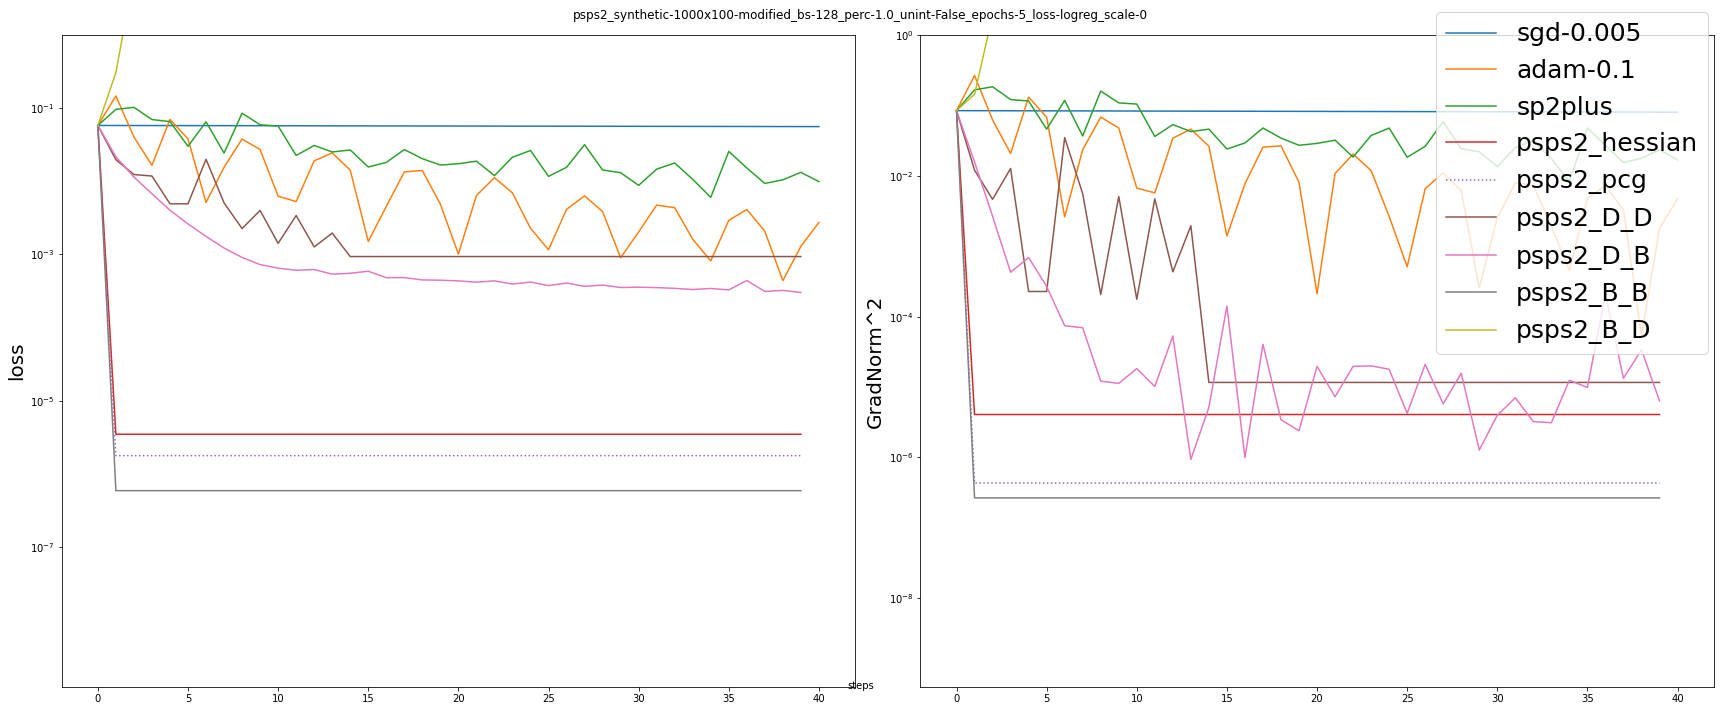

In [149]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))


ax1.semilogy([x[0] for x in hist_sgd])
ax1.semilogy([x[0] for x in hist_adam])
ax1.semilogy([x[0] for x in hist_sp2plus])
ax1.semilogy([x[0] for x in hist_psps2_hessian])
ax1.semilogy([x[0] for x in hist_psps2_pcg], linestyle=":")
ax1.semilogy([x[0] for x in hist_psps2_D_D])
ax1.semilogy([x[0] for x in hist_psps2_D_B])
ax1.semilogy([x[0] for x in hist_psps2_B_B])
ax1.semilogy([x[0] for x in hist_psps2_B_D])


ax2.semilogy([x[1] for x in hist_sgd])
ax2.semilogy([x[1] for x in hist_adam])
ax2.semilogy([x[1] for x in hist_sp2plus])
ax2.semilogy([x[1] for x in hist_psps2_hessian])
ax2.semilogy([x[1] for x in hist_psps2_pcg], linestyle=":")
ax2.semilogy([x[1] for x in hist_psps2_D_D])
ax2.semilogy([x[1] for x in hist_psps2_D_B])
ax2.semilogy([x[1] for x in hist_psps2_B_B])
ax2.semilogy([x[1] for x in hist_psps2_B_D])


ax1.set_ylabel('loss', fontsize=20)
ax1.set_ylim(top=1.0)

ax2.set_ylabel('GradNorm^2', fontsize=20)
ax2.set_ylim(top=1.0)


fig.text(0.5, 0.04, 'steps', ha='center', va='center', )

subtitle = f"psps2_{dataset_name}_bs-{batch_size}_perc-{percentage}_unint-{uninterpolatible}_epochs-{EPOCHS}_loss-{loss_name}_scale-{scale_k}"

fig.suptitle(subtitle)
fig.legend([f'sgd-{sgd_lr}', f'adam-{adam_lr}', 'sp2plus', 'psps2_hessian', 'psps2_pcg', 'psps2_D_D', 'psps2_D_B', 'psps2_B_B', 'psps2_B_D'], prop={'size': 25})
plt.tight_layout()
fig.show()

# fig.savefig(f"temp_plots/{subtitle}.png", 
#             dpi=200,
#             format="png",
#             transparent=False
#             )

In [12]:
def run_psps2_sr1():
    # parameters
    alpha = 1e-4
    beta=0.999
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

    loss_function = loss_class(w)

    # save loss and grad size to history
    hist = []
    loss = loss_function(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    f_grad = g.clone().detach()
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")

    lmd = torch.tensor(0.0)
    hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), lmd])

    # preconditioninig matrix
    s = torch.zeros_like(w) # s = H_inv * grad
    r = f_grad - torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
    p = r.detach().clone()
    r_prev = torch.dot(r, r)

    MAX_ITER = 100


    for epoch in range(EPOCHS):

        for i, (batch_data, batch_target) in enumerate(train_dataloader):

            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            loss = loss_function(batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.clone().detach()

            s = torch.zeros_like(w) # s = H_inv * grad
            r = f_grad.clone()
            p = r.detach().clone()

            for cg_step in range(MAX_ITER):
                hvp = torch.autograd.grad(g, w, grad_outputs=p, retain_graph=True)[0]
                alpha_k = torch.dot(r, r) / torch.dot(p, hvp)
                s = s + alpha_k * p
                r_prev = r.clone()
                r = r - alpha_k * hvp
                if torch.norm(r) < 1e-10:
                    Ax = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]    
                    diff = torch.norm(Ax - f_grad)
                    print(f"Took {cg_step} to reach diff={diff}")
                    break

                beta_k = torch.dot(r, r) / torch.dot(r_prev, r_prev)
                p = r + beta_k * p
            
            gnorm_sq = torch.dot(f_grad, s)

            print(f"loss: {loss.item()}")
            print(f"f_grad norm: {torch.norm(f_grad)}")
            print(f"gnorm_sq norm: {torch.norm(gnorm_sq)}")

            # det = (-gnorm_sq) / (2 * loss.item() - gnorm_sq) 
            # print(f"det: {det}")
            # if det <= 1e-40:
            #     print("no solutions")
            #     continue
            # else:
            #     lmd_1 = -1 + torch.sqrt(det)
            #     lmd_2 = -1 - torch.sqrt(det)
            #     lmd = torch.maximum(lmd_1, lmd_2)

            #     print(f"lmds: {lmd_1, lmd_2}")

            phi = 2 * loss.item() - gnorm_sq
            lmds = citardouq_solve(phi, 2 * phi, 2 * loss.item())
            lmd = np.max(lmds)
            print(f"lmds: {lmds}")
            print("======================")

            # lmd = torch.tensor(0.1)

            step = lmd / (1 + lmd) * s 

            with torch.no_grad():
                w.sub_(step)


        loss = loss_function(train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        print(f"[{epoch+1}/{EPOCHS}] | Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
        hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), lmd.item()])


    return hist

# PSPS2
$w^{t+1} \in \arg \textstyle{\min}_{w \in \mathbb{R}^d}\frac{1}{2} \| w - w^t \|_{D}^2\nonumber \\ 
\text{s.t.} \quad f_i(w^t)+\langle \nabla f_i(w^t), w - w^t \rangle +\frac{1}{2}\langle B(w-w^t), w - w^t \rangle \leq 0. \nonumber$

In [13]:
def run_bpsps2(precond_method="none"):

    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

    loss_function = loss_class(w)

    # save loss and grad size to history
    hist_bpsps2 = []
    loss = loss_function(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
    lmd_star = 0.0
    hist_bpsps2.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), lmd_star])

    # preconditioninig matrix
    if precond_method == "none":
        Dk = torch.ones_like(w)
        Dk_hat_inv = torch.ones_like(w)
    elif precond_method == "hutch":
        Dk = diag_estimate_old(w, g, 100)
    elif precond_method == "sr1":
        Dk_hat_inv = torch.ones_like(w)

    logs = {
        'loss': [],
        'gnorm': [],
        'yknorm': [],
        'D_inv_B norm': [],
        'D_inv_B_D_inv norm': [],
        'Dk_hat_inv norm': [],
        'a': [],
        'b': [],
        'c': [],
        'AA': [],
        'BB': [],
        'CC': [],
        'DD': [],
        'Precond norm': [],
        'lmd_star': [],
    }


    for epoch in range(EPOCHS):
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            loss = loss_function(batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.clone().detach()

            sk = f_grad.clone()
            yk = torch.autograd.grad(g, w, grad_outputs=sk, retain_graph=True)[0]
            # yk2 = torch.square(Dk_hat_inv) * sk
            # yk2 = torch.autograd.grad(torch.square(g), w, grad_outputs=sk, retain_graph=True)[0]

            if precond_method == "hutch" or precond_method == "none":

                if precond_method == "hutch":
                    vk = diag_estimate_old(w, g, 1)
                    # Smoothing and Truncation 
                    Dk = beta * Dk + (1 - beta) * vk
                    Dk_hat = torch.abs(Dk)
                    Dk_hat[Dk_hat < alpha] = alpha
                    Dk_hat_inv = 1 / Dk_hat  

                gnorm = (g * Dk_hat_inv).dot(g)

                D_inv = torch.diagflat(Dk_hat_inv.clone().detach())

                D_inv_B = (((Dk_hat_inv * yk).reshape(-1, 1) @ yk.reshape(1, -1)) / (yk.dot(sk)))
                D_inv_B_D_inv = D_inv_B * Dk_hat_inv

                a_torch = torch.dot(f_grad, Dk_hat_inv*f_grad)
                a = a_torch.cpu().detach().numpy()

                b_torch = torch.dot(f_grad, D_inv_B_D_inv@f_grad)
                b = b_torch.cpu().detach().numpy() 

                c_torch = torch.trace(D_inv_B)
                c = c_torch.cpu().detach().numpy()

            elif precond_method == "sr1":
                Dk_hat_inv = (((sk).reshape(-1, 1) @ sk.reshape(1, -1)) / (yk.dot(sk)))
                gnorm = (g @ Dk_hat_inv).dot(g)
                D_inv = Dk_hat_inv.clone().detach()

                D_inv_B = torch.eye(D_inv.shape[0])
                D_inv_B_D_inv = Dk_hat_inv.clone().detach()

                a_torch = torch.dot(f_grad, D_inv @ f_grad)
                a = a_torch.cpu().detach().numpy()

                b_torch = torch.dot(f_grad, D_inv_B_D_inv@f_grad)
                b = b_torch.cpu().detach().numpy() 

                c_torch = torch.trace(D_inv_B)
                c = c_torch.cpu().detach().numpy()


            # if torch.linalg.norm(f_grad) < 1e-8:
            #     continue

            # if torch.any(torch.isnan(torch.tensor([a_torch, b_torch, c_torch]))):
            #     continue

            # AA = 2 * a * c**2 - 2 * b * c
            # BB = 4 * a * c - 2 * loss.item() * c**2 - 3 * b
            AA = 2 * c**2 * ( torch.dot(f_grad, (D_inv - (1/c) * D_inv_B_D_inv ) @ f_grad) )
            BB = c_torch * ( torch.dot(f_grad, (4 * D_inv - (3/c) * D_inv_B_D_inv) @ f_grad) )
            CC = 2 * a - 4 * c * loss.item()
            DD = - 2 * loss.item()

            # BB = BB / AA
            # CC = CC / AA
            # DD = DD / AA
            # AA = 1.0
            
            def lagr(lmd):
                b = lambda lmd: D_inv - (lmd * (D_inv_B_D_inv) / (1 + lmd * c_torch)) 
                return lmd * loss -  (1/2)*lmd**2 * torch.dot(f_grad, b(lmd)@f_grad)



            # print("loss: ", loss)
            # print(f"g norm : {torch.norm(g)}")
            # print(f"yk norm: {torch.norm(yk)}")
            # print(f"D_inv_B norm: {torch.norm(D_inv_B)}")
            # print(f"D_inv_B_D_inv norm: {torch.norm(D_inv_B_D_inv)}")
            # print(f"Dk_hat_inv norm: {torch.norm(Dk_hat_inv)}")
            # print(f"a: {a}")
            # print(f"b: {b}")
            # print(f"c: {c}") 
            # print(f"plms: {AA} {BB} {CC} {DD}")

            lmd_star_old = lmd_star
            lmds = solve(AA, BB, CC, DD)
            lmds = torch.from_numpy(lmds).to(device)
            lmd_max = torch.max(lmds)
            lmd_min = torch.maximum(torch.min(lmds), torch.tensor(0))
            lmd_star = lmd_max
            if lagr(lmd_max) < lagr(lmd_min):
                lmd_star = lmd_min

            if lmd_star > 1e8:
                print(f"lmd_star is: {lmd_star}")
                lmd_star = lmd_star_old
            
            precond = lmd_star * ( D_inv - (lmd_star * (D_inv_B_D_inv) / (1 + lmd_star * c_torch)) )

            # print("Precond norm: ", torch.linalg.norm(precond))
            # print("lmds: ", lmds)
            # print("lmd_star: ", lmd_star)
            # print("==================")

            logs['loss'].append(loss)
            logs["gnorm"].append(torch.norm(g).item())
            logs["yknorm"].append(torch.norm(yk).item())
            logs["D_inv_B norm"].append(torch.norm(D_inv_B).item())
            logs["D_inv_B_D_inv norm"].append(torch.norm(D_inv_B_D_inv).item())
            logs["Dk_hat_inv norm"].append(torch.norm(Dk_hat_inv).item())
            logs["a"].append(a)
            logs["b"].append(b)
            logs["c"].append(c)
            logs["AA"].append(AA)
            logs["BB"].append(BB)
            logs["CC"].append(CC)
            logs["DD"].append(DD)
            logs["Precond norm"].append(torch.linalg.norm(precond))
            logs["lmd_star"].append(lmd_star)


            with torch.no_grad():
                w.sub_(precond @ f_grad)

        loss = loss_function(train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        print(f"Epoch[{epoch+1}/{EPOCHS}] | Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
        hist_bpsps2.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), lmd_star.item()])

    return hist_bpsps2